# 1. Install Dependencies and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [ ]:
#!unzip "/content/drive/MyDrive/paper 3 siham/data/data2_OP.zip" -d "/content/drive/MyDrive/paper 3 siham/data"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame150.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame180.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame210.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame240.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame270.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame30.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame300.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame330.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_xgboost/data2_OP/1.no_cheating/90frame360.jpg  
  inflating: /content/drive/MyDrive/cnn_mobilnet_x

In [3]:
cd /content/drive/MyDrive/paper 3 siham/data/data2_OP

/content/drive/MyDrive/paper 3 siham/data/data2_OP


In [ ]:
!pwd

# 2. Load and split Data

In [4]:
#BATCH_SIZE = 32
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/paper 3 siham/data/data2_OP"

In [5]:
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,  # Keep this for validation set
                                             subset='training',
                                             seed=42)

# Adjust the validation_split parameter for validation_dataset
validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,  # 20% for validation
                                                  subset='validation',
                                                  seed=42)

# Adjust the validation_split parameter for test_dataset
test_dataset = image_dataset_from_directory(directory,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            validation_split=0.1,  # 10% for testing
                                            subset='validation',  # Use 'validation' subset
                                            seed=42)


Found 9609 files belonging to 2 classes.
Using 6727 files for training.
Found 9609 files belonging to 2 classes.
Using 1921 files for validation.
Found 9609 files belonging to 2 classes.
Using 960 files for validation.


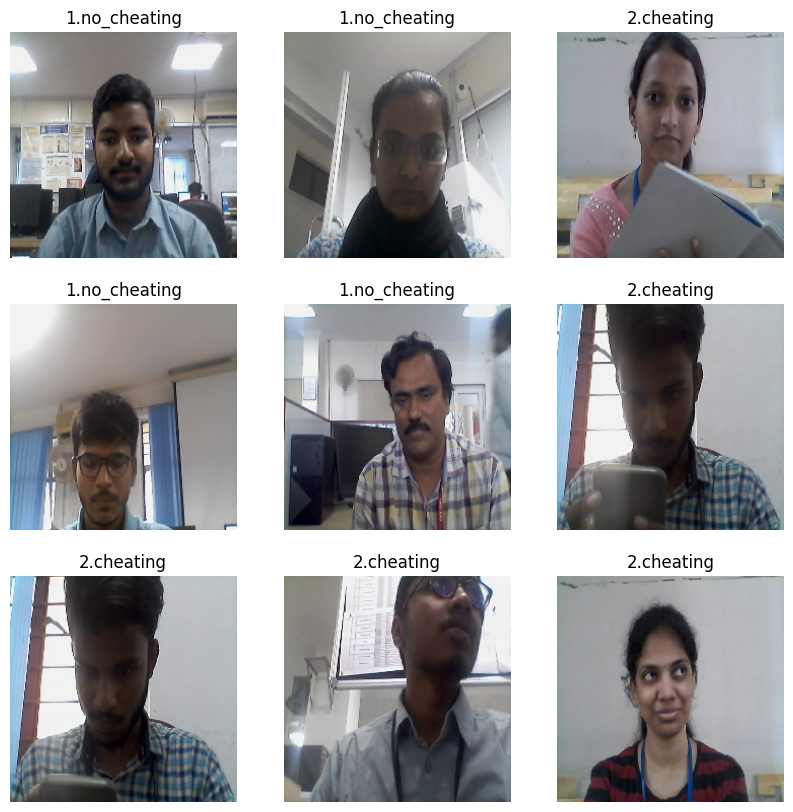

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 3. Data augmentation

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    # data_augmentation = None
    # data_augmentation.add(None)
    # data_augmentation.add(None)
    # YOUR CODE STARTS HERE
    data_augmentation = tf.keras.Sequential([
  tfl.experimental.preprocessing.RandomFlip("horizontal"),
  tfl.experimental.preprocessing.RandomRotation(0.2),
])
    # YOUR CODE ENDS HERE

    return data_augmentation

In [9]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')


All tests passed!


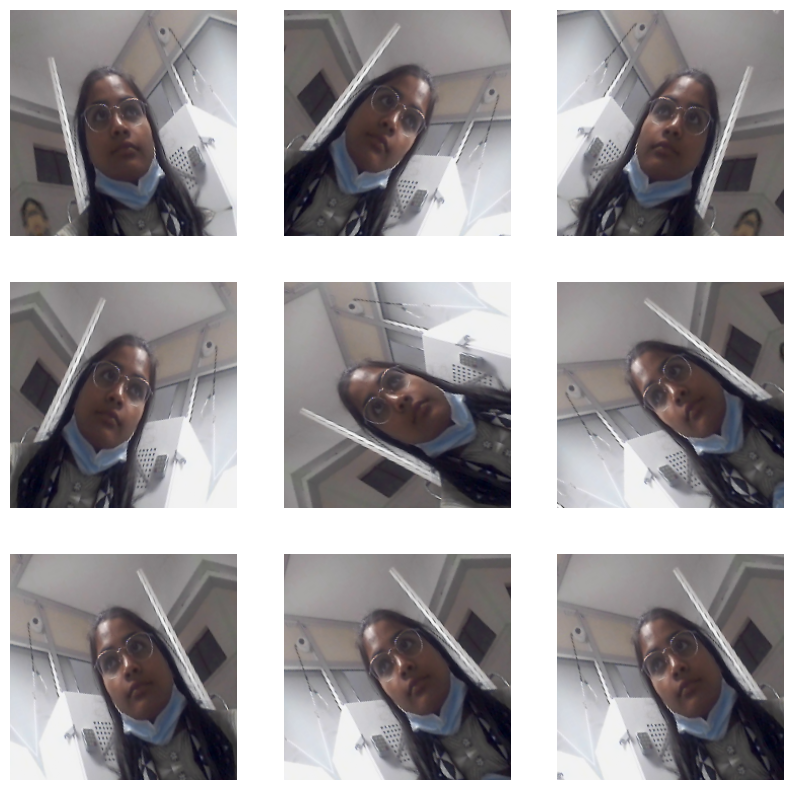

In [10]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# 4.Model call and configuration

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 1s 0us/step


In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [14]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 1000)


In [16]:
#Shows the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int32)>

In [17]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n03938244', 'pillow', 0.4160345),
  ('n04209239', 'shower_curtain', 0.12508883)],
 [('n04209239', 'shower_curtain', 0.78041965),
  ('n03938244', 'pillow', 0.18925804)],
 [('n04209239', 'shower_curtain', 0.81432974),
  ('n03938244', 'pillow', 0.042581648)],
 [('n04209239', 'shower_curtain', 0.6885298),
  ('n03938244', 'pillow', 0.19817631)],
 [('n03938244', 'pillow', 0.51776516),
  ('n04209239', 'shower_curtain', 0.17453948)],
 [('n03938244', 'pillow', 0.31014612),
  ('n04209239', 'shower_curtain', 0.17139105)],
 [('n04209239', 'shower_curtain', 0.46184582),
  ('n03938244', 'pillow', 0.36564255)],
 [('n04209239', 'shower_curtain', 0.7930088),
  ('n03938244', 'pillow', 0.06444715)],
 [('n04209239', 'shower_curtain', 0.3226143),
  ('n03938244', 'pillow', 0.20658799)],
 [('n04209239', 'shower_curtain', 0.80070823),
  ('n03938244', 'pillow', 0.092084564)],
 [('n04209239', 'shower_curtain', 0.98969346),
  ('n03938244', 'pillow', 0.0010868028)],
 [('n04209239', 'shower_curtain', 0.7252113

In [18]:
###test this updated code#################goodaccuracy########################
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Add, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
def alpaca_model(image_shape=(224, 224), data_augmentation=None):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    input_shape = image_shape + (3,)
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    if data_augmentation is not None:
        x = data_augmentation(x)

    x = preprocess_input(x)
    x = base_model(x, training=False)
    
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)  # Add a dense layer for more capacity
    outputs = Dense(1, activation='sigmoid')(x)  # Changed to sigmoid for binary classification

    model = tf.keras.Model(inputs, outputs)

    return model


In [19]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9406464/9406464 [==============================] - 1s 0us/step


In [20]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [21]:
data_augmentation

In [22]:
#from test_utils import summary, comparator
from tensorflow import summary

In [24]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 5.Model Training

In [26]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
from tensorflow.keras import callbacks

CALLBACKS = [
    callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=7, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto')
]

In [28]:
import time
t1=time.time()
initial_epochs = 60
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=CALLBACKS)
t2= time.time()
temps_execution = t2 - t1
print(f"Le temps d'exécution est de {temps_execution} secondes.")

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


421/421 [==============================] - 1247s 3s/step - loss: 0.4497 - accuracy: 0.7941 - val_loss: 0.3313 - val_accuracy: 0.8516 - lr: 0.0100
Epoch 2/60
421/421 [==============================] - 29s 68ms/step - loss: 0.3529 - accuracy: 0.8371 - val_loss: 0.3033 - val_accuracy: 0.8615 - lr: 0.0100
Epoch 3/60
421/421 [==============================] - 29s 68ms/step - loss: 0.3391 - accuracy: 0.8399 - val_loss: 0.3237 - val_accuracy: 0.8579 - lr: 0.0100
Epoch 4/60
421/421 [==============================] - 29s 68ms/step - loss: 0.3228 - accuracy: 0.8527 - val_loss: 0.3416 - val_accuracy: 0.8485 - lr: 0.0100
Epoch 5/60
421/421 [==============================] - 28s 67ms/step - loss: 0.3212 - accuracy: 0.8610 - val_loss: 0.2928 - val_accuracy: 0.8615 - lr: 0.0100
Epoch 6/60
421/421 [==============================] - 29s 68ms/step - loss: 0.3060 - accuracy: 0.8646 - val_loss: 0.3223 - val_accuracy: 0.8558 - lr: 0.0100
Epoch 7/60
421/421 [==============================] - 29s 69ms/step -

# 6. Plot Performance

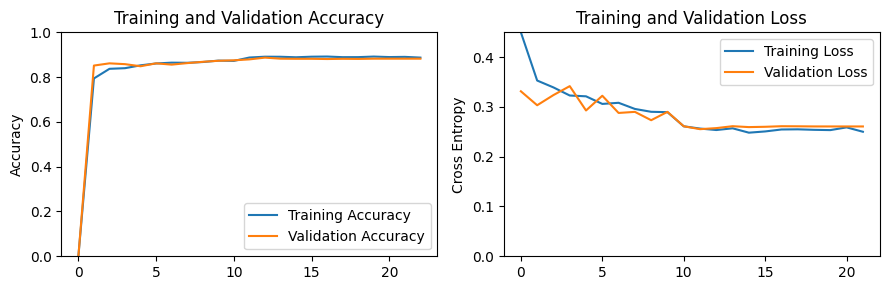

In [30]:
import matplotlib.pyplot as plt

# Assuming 'history' contains your training history

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots in the same row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

# Plot accuracy
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([min(min(acc), min(val_acc)), 1])
ax1.set_title('Training and Validation Accuracy')

# Plot loss
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0, max(max(loss), max(val_loss))])
ax2.set_title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# 7. Evaluate the model

In [32]:
model2.evaluate(train_dataset)

421/421 [==============================] - 23s 55ms/step - loss: 0.2485 - accuracy: 0.8943


[0.24845340847969055, 0.8943065404891968]

In [33]:
loss, accuracy = model2.evaluate(train_dataset)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

421/421 [==============================] - 21s 49ms/step - loss: 0.2485 - accuracy: 0.8943
Test: accuracy = 0.894307  ;  loss = 0.248453 


In [34]:
t3=time.time()
model2.evaluate(test_dataset)
t4= time.time()
temps_execution = t4 - t3
print(f"Le temps d'exécution est de {temps_execution} secondes.")

60/60 [==============================] - 3s 42ms/step - loss: 0.2692 - accuracy: 0.8687
Le temps d'exécution est de 2.863734722137451 secondes.


In [35]:
loss, accuracy = model2.evaluate(test_dataset)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

60/60 [==============================] - 3s 39ms/step - loss: 0.2692 - accuracy: 0.8687
Test: accuracy = 0.868750  ;  loss = 0.269224 


In [36]:
y_pred = []  # store predicted labels
y_true = []  # store true labels
y_pred1 = []
# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds= model2.predict(image_batch)
   # append predicted labels
   # y_pred.append(np.argmax(preds, axis = - 1))
   #y_pred.append( preds.argmax(axis = 1))
   #y_pred=rech(preds)
   y_pred=np.where(preds> 0.5, 1,0)
   y_pred1.append(y_pred)
# convert the true and predicted labels into tensors
yr= tf.concat([item for item in y_true], axis = 0)
yp = tf.concat([item for item in y_pred1], axis = 0)

1/1 [==============================] - 0s 37ms/step


In [37]:
from sklearn.metrics import classification_report

In [38]:
report = classification_report(yr,yp)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       462
           1       0.90      0.84      0.87       498

    accuracy                           0.87       960
   macro avg       0.87      0.87      0.87       960
weighted avg       0.87      0.87      0.87       960



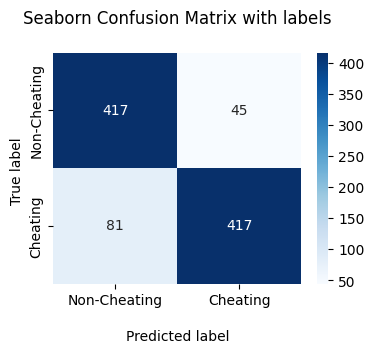

In [39]:
from sklearn.metrics import confusion_matrix
# importing library for plotting
import matplotlib.pyplot as plt
# plot the confusion matrix
f,ax = plt.subplots(figsize=(4,3))
#Generate the confusion matrix
cf_matrix = confusion_matrix(yr, yp)
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap=plt.cm.Blues, fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non-Cheating','Cheating'])
ax.yaxis.set_ticklabels(['Non-Cheating','Cheating'])

## Display the visualization of the Confusion Matrix.
plt.show()

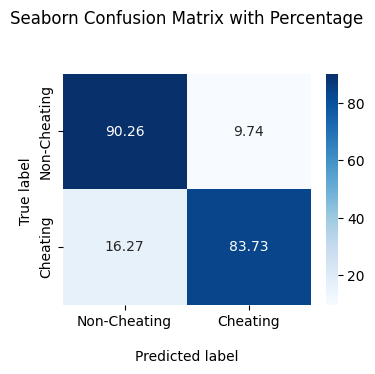

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
f,ax = plt.subplots(figsize=(4,3))
# Generate the confusion matrix
cf_matrix = confusion_matrix(yr, yp)

# Calculate the percentages
cf_matrix_percent = cf_matrix / cf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create the heatmap
ax = sns.heatmap(cf_matrix_percent, annot=True, cmap=plt.cm.Blues, fmt='.2f')

# Set the title and labels
ax.set_title('Seaborn Confusion Matrix with Percentage\n\n')
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label ')

# Set tick labels
ax.xaxis.set_ticklabels(['Non-Cheating', 'Cheating'])
ax.yaxis.set_ticklabels(['Non-Cheating', 'Cheating'])

# Display the visualization of the Confusion Matrix with percentage
plt.show()


In [41]:
import numpy as np
from sklearn.metrics import f1_score

print('f1_score=',f1_score(yr, yp, average='macro'))

f1_score= 0.86875


In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [44]:
for batch in test_dataset.as_numpy_iterator():
    X, y = batch
    yhat = model2.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 25ms/step


In [45]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9025974, shape=(), dtype=float32) tf.Tensor(0.8373494, shape=(), dtype=float32) tf.Tensor(0.86875, shape=(), dtype=float32)


In [46]:
import numpy as np
from sklearn.metrics import det_curve
fpr, fnr, thresholds = det_curve(yr, yp)
print(fpr)

[1.        0.0974026]


# 8.Save the Model

In [47]:
from tensorflow.keras.models import load_model

In [49]:
model2.save(os.path.join('/content/drive/MyDrive/paper 3 siham/data/models','1.data2_mobilnet.h5'))

In [50]:
new_model = load_model('/content/drive/MyDrive/paper 3 siham/data/models/1.data2_mobilnet.h5')

In [51]:
new_model.evaluate(train_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


421/421 [==============================] - 24s 50ms/step - loss: 0.2485 - accuracy: 0.8943


[0.24845339357852936, 0.8943065404891968]

In [52]:
new_model.evaluate(test_dataset)

60/60 [==============================] - 5s 67ms/step - loss: 0.2692 - accuracy: 0.8687


[0.26922407746315, 0.8687499761581421]